In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" an

In [6]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import time
import evaluate

# Define models
models = [
    "bigscience/bloom-560m",
    "facebook/opt-1.3b",
    "microsoft/DialoGPT-small",
    "openai-community/gpt2",
    "EleutherAI/gpt-neo-125M"
]

# Sample prompt
prompt = "This is my data science assignment"

# BLEU Score Evaluator
bleu = evaluate.load("bleu")

# Store results
data = []

for model_name in models:
    print(f"Evaluating {model_name}...")

    # Load model & tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Inference Time
    inputs = tokenizer(prompt, return_tensors="pt")
    start_time = time.time()
    output = model.generate(**inputs, max_length=50)
    inference_time = time.time() - start_time

    # Generated text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    # Model size (in MB)
    model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024**2)

    # Compute BLEU Score (Fluency)
    reference = ["This is my data science assignment of predictive analysis."]
    fluency = bleu.compute(predictions=[generated_text], references=[reference])["bleu"]

    # Append data
    data.append([model_name, model_size, inference_time, fluency])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Model Name", "Model Size (MB)", "Inference Time (s)", "Fluency (BLEU Score)"])

Evaluating bigscience/bloom-560m...
Evaluating facebook/opt-1.3b...
Evaluating microsoft/DialoGPT-small...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Evaluating openai-community/gpt2...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Evaluating EleutherAI/gpt-neo-125M...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [7]:
df.head()

,Model Name,Model Size (MB),Inference Time (s),Fluency (BLEU Score)
0,bigscience/bloom-560m,2133.234375,11.331250,0.096535
1,facebook/opt-1.3b,5019.218750,23.783032,0.105217
2,microsoft/DialoGPT-small,474.700195,0.213677,0.547793
3,openai-community/gpt2,474.700195,2.691859,0.110172
4,EleutherAI/gpt-neo-125M,477.594727,5.865671,0.096535


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Extract numerical values from the dataframe (assuming df is your dataframe)
decision_matrix = df.iloc[:, 1:].values.astype(float)

# Define weights (adjust the weights array to have 5 elements)
weights = np.array([1, 2, 1, 1, 1])  # 5 criteria weights, one for each column

# Define criteria (Higher is better: Fluency; Lower is better: Model Size, Inference Time)
criteria = np.array([-1, -1, 1, 1, 1])  # -1 for minimization, 1 for maximization for each criterion

# Normalize the decision matrix
norm_matrix = decision_matrix / np.sqrt((decision_matrix**2).sum(axis=0))

# Weighted normalized decision matrix
weighted_matrix = norm_matrix * weights

# Identify ideal best and worst values
ideal_best = np.where(criteria == 1, weighted_matrix.max(axis=0), weighted_matrix.min(axis=0))
ideal_worst = np.where(criteria == 1, weighted_matrix.min(axis=0), weighted_matrix.max(axis=0))

# Compute Euclidean distances
dist_best = np.sqrt(((weighted_matrix - ideal_best) ** 2).sum(axis=1))
dist_worst = np.sqrt(((weighted_matrix - ideal_worst) ** 2).sum(axis=1))

# Calculate TOPSIS score
topsis_score = dist_worst / (dist_best + dist_worst)

# Add results to DataFrame
df["TOPSIS Score"] = topsis_score
df["Rank"] = df["TOPSIS Score"].rank(ascending=False)

# Sort and print results
df = df.sort_values(by="Rank")
print(df[['Model Name', 'TOPSIS Score', 'Rank']])

                 Model Name  TOPSIS Score  Rank
2  microsoft/DialoGPT-small      0.801433   1.0
3     openai-community/gpt2      0.672661   2.0
4   EleutherAI/gpt-neo-125M      0.635116   3.0
0     bigscience/bloom-560m      0.491347   4.0
1         facebook/opt-1.3b      0.199010   5.0


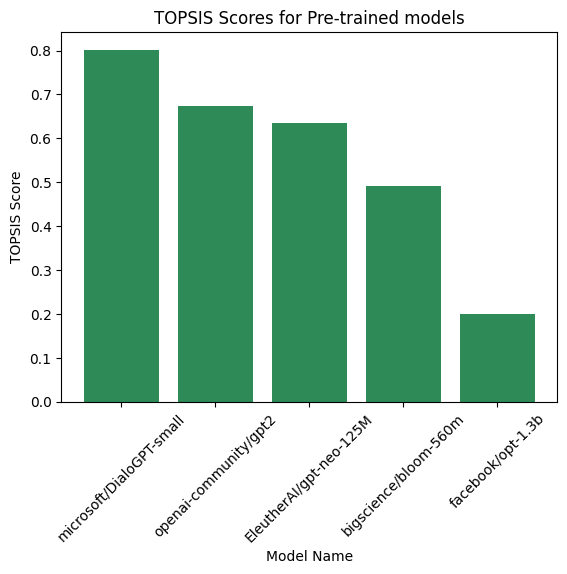

In [22]:
# Visualization 1: Bar Plot for TOPSIS Scores
plt.figure()
plt.bar(df['Model Name'], df['TOPSIS Score'], color='seagreen')
plt.xlabel('Model Name')
plt.ylabel('TOPSIS Score')
plt.title('TOPSIS Scores for Pre-trained models')
plt.xticks(rotation=45)
plt.show()

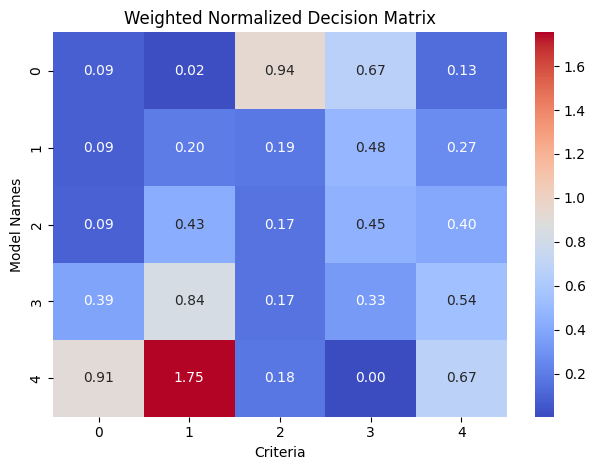

In [24]:
# Visualization 2: Heatmap for Weighted Normalized Matrix
plt.figure()
sns.heatmap(weighted_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Weighted Normalized Decision Matrix')
plt.xlabel('Criteria')
plt.ylabel('Model Names')
plt.tight_layout()
plt.show()